# Quantitative analysis of EELS finestructure

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

In [3]:
import hyperspy.api as hs
import numpy as np

 Check that the Hartree-Slater determinants are loaded:
 EELS -> Model -> GOS directory. Then go to the  UNZIPPED FOLDER.

In [4]:
hs.preferences.gui()

In [5]:
s = hs.load("EELS Spectrum Image (high-loss) (aligned).dm3")
s_ll = hs.load("EELS Spectrum Image (low-loss) (aligned).dm3")

In [6]:
#s.plot()

In [7]:
#s_ll.plot()

Edge energy parameters. [Start background , end background , start edge, end edge].

In [8]:
s_o_edge_E  = [503.,527.,517.,600.]
s_mn_edge_E = [602.,632.,620.,702.]

### Processing the data

We fix the energy offset by using the `align_zero_loss_peak` method:

In [9]:
s_ll.align_zero_loss_peak(subpixel=True,calibrate=True,also_align=[s])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-0.080
std:	0.000

min:	-0.080
Q1:	-0.080
median:	-0.080
Q3:	-0.080
max:	-0.080


In [10]:
s.change_dtype(float)
s_ll.change_dtype(float)

Now we can extract the different EELS edges, to make it easier to visualize them. For this we use the `isig` method, which is used to slice the signal axes. (The `inav` method is used to slice in navigation axes.)

In [11]:
s_mn = s.isig[s_mn_edge_E[0]:s_mn_edge_E[3]].deepcopy()

Then remove the power law background using the `remove_background` method. The fitting range for the background can either by specified using a GUI, or the `signal_range` variable. `fast=False` is used to get a better fit, but might take longer time for large datasets.

In [12]:
s_mn = s_mn.remove_background(signal_range=(s_mn_edge_E[0], s_mn_edge_E[1]), fast = True)

Add the Hartree-Slater cross section for Manganese and Oxygen to the signal, so that the models can be created next.

In [13]:
s_mn.add_elements(('Mn',))

## Modelling the Mn-L$_{2,3}$ core loss edge

Making a model object from the core loss and low loss signals. The low loss is important for this, since it allows for the model to be convolved with low loss. This makes the fitting better, and automatically takes into account the effect of multiple scattering. The low loss is added by using the `ll` variable, and since we've already removed the power law background we use the `auto_background=False`.

The low loss signal and the core loss signal must have the same navigation dimensions. Furthermore, due to a known issue (https://github.com/hyperspy/hyperspy/issues/1317) the "binned" parameter is set to false.

In [14]:
s_mn.metadata.Signal.binned = False
s_ll.metadata.Signal.binned = False

m_mn = s_mn.create_model(ll=s_ll, auto_background=False)

Currently, the model contains two components for modelling the Mn-L$_{2,3}$ EELS edge, which can be accessed in:

In [15]:
m_mn.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               Mn_L3 |               Mn_L3 |          EELSCLEdge
   1 |               Mn_L2 |               Mn_L2 |          EELSCLEdge

Running the fitting process to get some reasonable initial positions

In [16]:
m_mn.multifit()

The `onset_energy` parameter can be changed interactively using `enable_adjust_position`. Move the onset to a little bit before the L$_3$ peak onset. This can also be done by doing `m_mn.components.Mn_L3.onset_energy.value = 638`.

In [17]:
#m_mn.enable_adjust_position()

In [18]:
m_mn.components.Mn_L3.onset_energy.value = 638

This only sets the value temporarily for this one specific position. The `assign_current_value_to_all` method is used to make it permanent for all the positions

In [19]:
m_mn.components.Mn_L3.onset_energy.assign_current_value_to_all()

In [20]:
m_mn.components.Mn_L2.onset_energy.value = 649

In [21]:
m_mn.components.Mn_L2.onset_energy.assign_current_value_to_all()

The next step is making the fitting function ignore the intense L$_3$ and L$_2$ peaks, which we'll fit later using Gaussians. The regions used for the fitting can be specified interactively using `m_mn.set_signal_range()`. Set the signal range between 603 and 636 eV.

In [22]:
m_mn.set_signal_range(603, 636)

The use `add_signal_range` to add a second signal range at the lowest point in the edge background (659 to 693 eV)

In [23]:
m_mn.add_signal_range(659,693)

Now, the fitting algorithm will only fit the model to the regins we just specified

In [24]:
m_mn.multifit()

First we reset the signal range, so we can see the whole model.

In [25]:
m_mn.reset_the_signal_range()

Now the the edge background looks much better

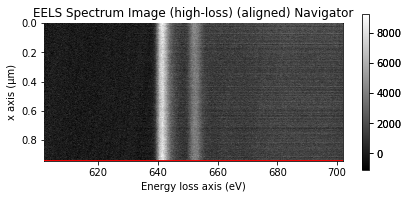

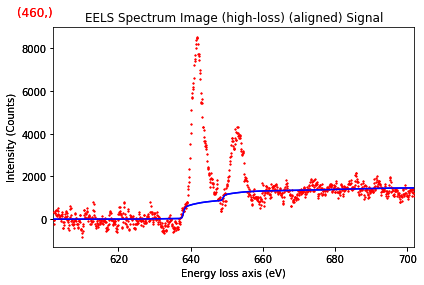

In [26]:
m_mn.plot()

We can now lock the EELSCLEdge component

In [27]:
m_mn.components.Mn_L2.set_parameters_not_free()
m_mn.components.Mn_L3.set_parameters_not_free()

This means the component will not change when fitting

### Adding the Gaussians

First we need to make two Gaussian components

In [28]:
g1 = hs.model.components1D.Gaussian()
g2 = hs.model.components1D.Gaussian()

These are added to the model using `append` (just like a standard Python list)

In [29]:
m_mn.append(g1)
m_mn.append(g2)

In [30]:
m_mn.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               Mn_L3 |               Mn_L3 |          EELSCLEdge
   1 |               Mn_L2 |               Mn_L2 |          EELSCLEdge
   2 |            Gaussian |            Gaussian |            Gaussian
   3 |          Gaussian_0 |          Gaussian_0 |            Gaussian

Before trying to fit them to the signal, we should give them some reasonable initial values. 

In [31]:
m_mn.fit_component(g1, signal_range=(637.45, 648.32), only_current = False)

In [32]:
m_mn.fit_component(g2,signal_range=(649, 657), only_current = False)

Now that the two Gaussian components have some reasonable initial values, we can try fitting both of them at the same time. But first we want to change the signal range so it does not contain all of the edge background. Use `set_signal_range` to set the fitting range from 635 to 661 eV.

In [33]:
m_mn.set_signal_range(635,661)

The fitting is better, but not perfect. One issue is the intensity in the edge background "behind" the two main peaks is not very good at the moment. This is due to the plural scattering from the Gaussians now contributing intensity.

This is solved by letting the intensity parameter for the EELSCLEdge component be free.

In [34]:
m_mn.components.Mn_L3.intensity.free = True

In [35]:
m_mn.multifit()

In [36]:
m_mn.reset_signal_range()

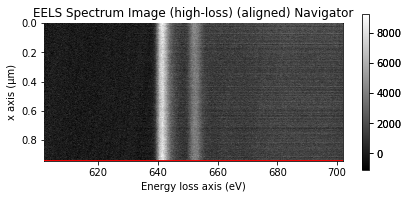

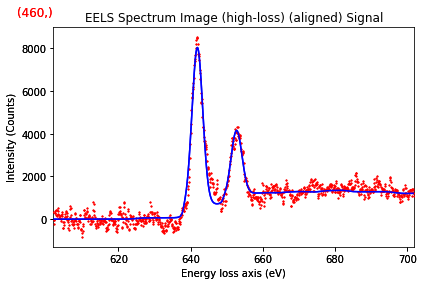

In [37]:
m_mn.plot()

However, the amplitude in the model is not correct at all. From the fit it seems to be of order $8000 \cdot \sqrt{2\pi \cdot \sigma^2}$. However, it is not consistent with the stored value.

In [38]:
m_mn.print_current_values()

Components	Parameter	Value
Mn_L3
		intensity	6.8657e-05
Mn_L2
Gaussian
		A	0.152032
		centre	641.778
		sigma	1.43289
Gaussian_0
		A	0.0652113
		centre	652.631
		sigma	1.46371


The observed height of L$_3$ should be $\frac{0.152032}{\sqrt{2\pi \cdot 1.43289^2}}$ = 0.0423.

In [49]:
m_mn[2].A.value/np.sqrt(2.0*np.pi*m_mn[2].sigma.value*m_mn[2].sigma.value)

0.042328452787458108

There has been an issue with the binning parameter before (https://github.com/hyperspy/hyperspy/issues/1317). However, the binning parameter is set to False (setting it to true does not solve the problem either).

In [40]:
s_mn.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       ├── aperture_size = 5.0
│       │       ├── collection_angle = 66.9000015258789
│       │       ├── frame_number = 1
│       │       └── spectrometer = GIF Quantum ER
│       ├── acquisition_mode = STEM
│       ├── beam_current = 0.0
│       ├── beam_energy = 200.0
│       ├── camera_length = 15.0
│       ├── convergence_angle = 27.0
│       ├── magnification = 200000.0
│       └── microscope = JEM-ARM200F
├── General
│   ├── original_filename = EELS Spectrum Image (high-loss) (aligned).dm3
│   └── title = EELS Spectrum Image (high-loss) (aligned)
├── Sample
│   ├── description = DWNC
│   └── elements = ['Mn']
└── Signal
    ├── binned = False
    ├── quantity = Intensity (Counts)
    └── signal_type = EELS

In [41]:
s_ll.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       ├── aperture_size = 5.0
│       │       ├── collection_angle = 66.9000015258789
│       │       ├── frame_number = 1
│       │       └── spectrometer = GIF Quantum ER
│       ├── acquisition_mode = STEM
│       ├── beam_current = 0.0
│       ├── beam_energy = 200.0
│       ├── camera_length = 15.0
│       ├── convergence_angle = 27.0
│       ├── magnification = 200000.0
│       └── microscope = JEM-ARM200F
├── General
│   ├── original_filename = EELS Spectrum Image (low-loss) (aligned).dm3
│   └── title = EELS Spectrum Image (low-loss) (aligned)
├── Sample
│   └── description = DWNC
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor = 1.0
    │       └── gain_offset = 0.0
    ├── binned = False
    ├── quantity = Intensity (Counts)
    └── signal_type = EELS

I now do a test, to see that the model outputs the correct amplitude in a dummy model. It does.

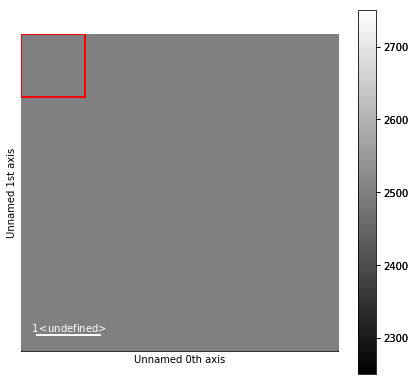

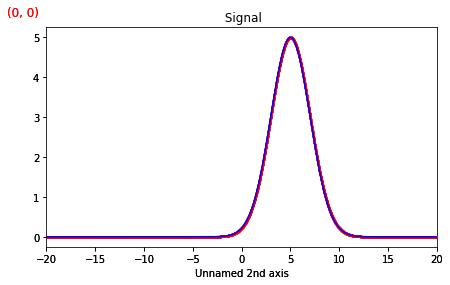

In [42]:
g1 = hs.model.components1D.Gaussian(A=25.0, sigma=2.0, centre=5.0)
x = np.arange(-20, 20, 0.01)
data = np.zeros((5,5,4000))
data[:] = g1.function(x).reshape((1,1,4000))
s = hs.signals.Signal1D(data)

s.axes_manager._axes[-1].offset = -20
s.axes_manager._axes[-1].scale = 0.01
#s.plot()

g2 = hs.model.components1D.Gaussian()
m = s.create_model()
m.append(g2)
m.fit_component(g2)
m.multifit()

In [43]:
m.print_current_values()

Components	Parameter	Value
Gaussian
		A	25
		centre	5
		sigma	2


The height of the peak is about 5. This is consistent with the above Parameter Values, $\frac{A}{\sqrt{2\pi \cdot \sigma^2}}$ = 4.987.

In [44]:
m[0].A.value/np.sqrt(2.0*np.pi*m[0].sigma.value*m[0].sigma.value)

4.9867785050179085

My main question is why the amplitude appears to be wrong in the m_mn model above.

Below, I have additional more technical questions about how to normalize the white line sum. This is slightly related, because my normalization might be wrong if I get wrong values for the amplitudes, intensities etc.




------------------------------------------------------------------------------------------------------------------------



I am currently trying to compute the the white-line ratio and the normalized white-line sum for the Mn-L peaks according to the procedure proposed by Hiroki Kurata and Christian Colliex (https://journals.aps.org/prb/pdf/10.1103/PhysRevB.48.2102). 

My fit is 

$I(E) = \left(A \cdot E^{-r} + \lambda_2 \cdot \left[\sigma_{L_3}(E) + \sigma_{L_2}(E)\right] + aL_3 + bL_2 \right) \times I_{ll}(E)$

The first term is the power law subtraction, the second two terms the atomic cross sections, the next two terms the Gaussians, and then this is convolved with the low-loss, the last term.

The white-line ratio, $\frac{I(L_3)}{I(L_2)} = \frac{a}{b}$, should not be affected by the strange values of the amplitudes if both the amplitudes are reduced by the same factor. The values are also similar to what I would expect. I am still a bit uneasy about it though.

The normalized white-line sum for the Mn-L peaks is calculated according to

$I(L_3) + I(L_2) = \frac{a+b}{\lambda_2 \int \left[\sigma_2(E)+\sigma_3(E))\right] dE}$

The integral is over an 80 eV window in the ELNES region. I fear this parameter may be more distorted by the strange values of the amplitudes. My values are a factor 100 higher than what Colliex and Kurata got. a and b are way too low, but $\lambda_2 \sim 10^{-5}$ which is even lower..

Below, I compute the two parameters and then plot their mean over 300 nm line segments. My last question is if I have understood the HyperSpy parameters correctly. For example, I assume that $\lambda_2$ = m_mn[0].intensity.as_signal(). The documentation says the intensity Parameter corresponds to

"The factor by which the cross section is multiplied, what in favourable cases is proportional to the number of atoms of the element. It is a component.Parameter instance. It is fixed by default." 

(0, 0.9)

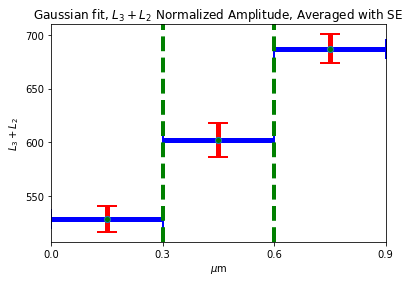

In [45]:
m_mn[0].fine_structure_width = 80
m_mn[1].fine_structure_width = 80

a = np.absolute(m_mn[2].A.as_signal())
b = np.absolute(m_mn[3].A.as_signal())

sigma_L3_integrated = np.absolute(m_mn[0].get_fine_structure_as_signal1D().sum(-1)).transpose()
sigma_L2_integrated = np.absolute(m_mn[1].get_fine_structure_as_signal1D().sum(-1)).transpose()

lambda_2 = np.absolute(m_mn[0].intensity.as_signal())

s_L32_sum = (a+b)/(lambda_2*(sigma_L2_integrated+sigma_L3_integrated))
s_L32_sum.metadata.General.title = 'I_L3 + I_L2'

s_L32_sum_av2 = []
s_L32_sum_s2 = []

s_L32_sum_av2.append(s_L32_sum.isig[0.0:0.300].mean(0))
s_L32_sum_s2.append(s_L32_sum.isig[0.0:0.300].std(0)/np.sqrt(len(s_L32_sum.isig[0.0:0.300].data)))

s_L32_sum_av2.append(s_L32_sum.isig[0.300:0.600].mean(0))
s_L32_sum_s2.append(s_L32_sum.isig[0.300:0.600].std(0)/np.sqrt(len(s_L32_sum.isig[0.300:0.600].data)))

s_L32_sum_av2.append(s_L32_sum.isig[0.600:0.900].mean(0))
s_L32_sum_s2.append(s_L32_sum.isig[0.600:0.900].std(0)/np.sqrt(len(s_L32_sum.isig[0.600:0.900].data)))

means2 = [s_L32_sum_av2[0].data[0], s_L32_sum_av2[1].data[0], s_L32_sum_av2[2].data[0]]
errors2 = [s_L32_sum_s2[0].data[0], s_L32_sum_s2[1].data[0], s_L32_sum_s2[2].data[0]]


mpl.pyplot.errorbar([0.150], means2[0], xerr=0.150, yerr=0, fmt='o', 
                    ecolor='b', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.150], means2[0], xerr=0, yerr=errors2[0], fmt='o', 
                    ecolor='r', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.450], means2[1], xerr=0.150, yerr=0, fmt='o', 
                    ecolor='b', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.450], means2[1], xerr=0, yerr=errors2[1], fmt='o', 
                    ecolor='r', mfc = 'g', capthick=2,capsize=10, elinewidth=5)


mpl.pyplot.errorbar([0.750], means2[2], xerr=0.150, yerr=0, fmt='o', 
                    ecolor='b', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.750], means2[2], xerr=0, yerr=errors2[2], fmt='o', 
                    ecolor='r', mfc = 'g', capthick=2,capsize=10, elinewidth=5)


mpl.pyplot.axvline(x=0.3, linewidth=4, color='g', linestyle='dashed')
mpl.pyplot.axvline(x=0.6, linewidth=4, color='g', linestyle='dashed')

mpl.pyplot.xticks([0, 0.3, 0.6,  0.9])
mpl.pyplot.title('Gaussian fit, $L_3+L_2$ Normalized Amplitude, Averaged with SE')
mpl.pyplot.xlabel('$\mu$m')
mpl.pyplot.ylabel('$L_3+L_2$')
mpl.rcParams.update({'font.size': 15})
mpl.pyplot.xlim([0, 0.9])

(0, 0.942)

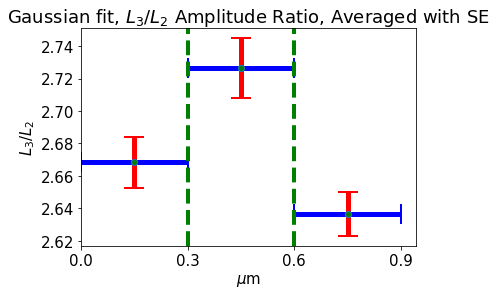

In [46]:
a = np.absolute(m_mn[2].A.as_signal())
b = np.absolute(m_mn[3].A.as_signal())

s_L32_ratio = np.absolute(a)/np.absolute(b)
s_L32_ratio.metadata.General.title = 'I_L3/I_L2'

s_L32_ratio_av2 = []
s_L32_ratio_s2 = []


s_L32_ratio_av2.append(s_L32_ratio.isig[0.0:0.300].mean(0))
s_L32_ratio_s2.append(s_L32_ratio.isig[0.0:0.300].std(0)/np.sqrt(len(s_L32_ratio.isig[0.0:0.300].data)))

s_L32_ratio_av2.append(s_L32_ratio.isig[0.300:0.600].mean(0))
s_L32_ratio_s2.append(s_L32_ratio.isig[0.300:0.600].std(0)/np.sqrt(len(s_L32_ratio.isig[0.300:0.600].data)))

s_L32_ratio_av2.append(s_L32_ratio.isig[0.600:0.900].mean(0))
s_L32_ratio_s2.append(s_L32_ratio.isig[0.600:0.900].std(0)/np.sqrt(len(s_L32_ratio.isig[0.600:0.900].data)))

means2 = [s_L32_ratio_av2[0].data[0], s_L32_ratio_av2[1].data[0], s_L32_ratio_av2[2].data[0]]
errors2 = [s_L32_ratio_s2[0].data[0], s_L32_ratio_s2[1].data[0], s_L32_ratio_s2[2].data[0]]


mpl.pyplot.errorbar([0.150], means2[0], xerr=0.150, yerr=0, fmt='o', 
                    ecolor='b', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.150], means2[0], xerr=0, yerr=errors2[0], fmt='o', 
                    ecolor='r', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.450], means2[1], xerr=0.150, yerr=0, fmt='o', 
                    ecolor='b', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.450], means2[1], xerr=0, yerr=errors2[1], fmt='o', 
                    ecolor='r', mfc = 'g', capthick=2,capsize=10, elinewidth=5)


mpl.pyplot.errorbar([0.750], means2[2], xerr=0.150, yerr=0, fmt='o', 
                    ecolor='b', mfc = 'g', capthick=2,capsize=10, elinewidth=5)

mpl.pyplot.errorbar([0.750], means2[2], xerr=0, yerr=errors2[2], fmt='o', 
                    ecolor='r', mfc = 'g', capthick=2,capsize=10, elinewidth=5)


mpl.pyplot.axvline(x=0.3, linewidth=4, color='g', linestyle='dashed')
mpl.pyplot.axvline(x=0.6, linewidth=4, color='g', linestyle='dashed')


mpl.pyplot.xticks([0, 0.3, 0.6, 0.9])
mpl.pyplot.title('Gaussian fit, $L_3/L_2$ Amplitude Ratio, Averaged with SE')
mpl.pyplot.xlabel('$\mu$m')
mpl.pyplot.ylabel('$L_3/L_2$')
mpl.rcParams.update({'font.size': 15})
mpl.pyplot.xlim([0, 0.942])

This is the fine structure, which I use for $\sigma_{L_3}(E)$.

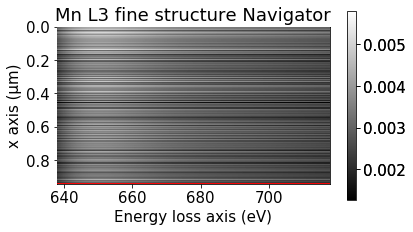

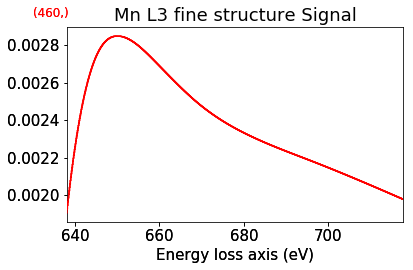

In [47]:
m_mn[0].get_fine_structure_as_signal1D().plot()

I have set fine_structure_active to False because it gives strange results when True. Does this setting simply imply that my computed fine structures have less features, i.e. is more smooth? Can I still use them to compute $\int \left[\sigma_2(E)+\sigma_3(E))\right] dE$?

In [48]:
m_mn[0].fine_structure_active

False